In [1]:
import numpy as np
import qiskit
from qiskit.quantum_info.operators import Operator
from qiskit.extensions import UnitaryGate
from qiskit.circuit.library import MCMT
from tools import *

# Trying to encode H(s) (Fig. 9 of Berry article) + reflection
(the qubit 'a' on the figure represents a register of possibly multiple qubits - here it is 2: q_1, q_2)

In [2]:
# See: https://qiskit.org/documentation/tutorials/circuits_advanced/02_operators_overview.html for instructions on user-defined operators

def get_Ua(A_mat: np.ndarray, q_2: int = 0) -> qiskit.quantum_info.operators.operator.Operator:
    """
    Constructs the unitary operator Ua that encodes a symmetric real 2x2 matrix 'A' as a quantum gate.

    Parameters
    ----------
    A_mat : np.ndarray
        The symmetric real 2x2 matrix to be encoded as a quantum gate.
    q_2 : int, optional
        The value of qubit 2, which should be either 0 or 1. Defaults to 0.

    Returns
    -------
    qiskit.quantum_info.operators.operator.Operator
        The operator Ua as a `qiskit.quantum_info.Operator` object.

    Raises
    ------
    ValueError
        If `q_2` is not equal to 0 or 1.
        If `A` is not a 2x2 symmetric real matrix.
    """


    if q_2 != 0 and q_2 != 1:
        raise ValueError("q_2 should have the value of either '0' or '1'. ")
    if A_mat.shape[0] != A_mat.shape[1] or A_mat.shape[0] != 2:
        raise ValueError("The given matrix 'A' should be 2x2.")
    if not check_symmetric(a=A_mat):
        raise ValueError("The given matrix 'A' should be symmetric.")
    if not np.all(np.isreal(A_mat)):
        raise ValueError("The given matrix 'A' should only contain real numbers.")

    # Normalizing w. respect to spectral norm
    _spectral_norm = np.sqrt(np.max(np.linalg.eigvals(A_mat.T@A_mat-np.eye(2))))
    _A_mat = 1/2*A/_spectral_norm
    # Updating alpha_1, alpha_2 definition
    _alpha_1, _alpha_2 = 2*_A_mat[0,0], 2*_A_mat[0,1]
    # Defining rotation angles
    _theta_1 = np.arccos(_alpha_1)
    _theta_2 = np.arccos(_alpha_2) - _theta_1

    _NR_QUBITS = 3
    _circ = QuantumCircuit(_NR_QUBITS)
    if q_2 == 0:
        _circ.x(qubit=2)
    _circ.h(qubit=1)
    _circ.cx(control_qubit=1,target_qubit=2)
    _circ.cu(theta=2*_theta_2,phi=0.0,gamma=0.0,lam=0.0,control_qubit=1,target_qubit=0) # N.B. Remember to rotate by the double amount
    _circ.u(theta=2*_theta_1, phi=0.0,lam=0.0,qubit=0) # N.B. Remember to rotate by the double amount
    _circ.h(qubit=1)
    _UA = Operator(_circ)
    _UA.name = f"$U_A$"
    return _UA

def get_Ub(b_vec: np.ndarray) -> qiskit.quantum_info.operators.operator.Operator:
    """
    Constructs the unitary operator Ub that encodes the 'b' vector as a quantum gate.

    Parameters
    ----------
    b_vec : numpy.ndarray
        A numpy array containing the 2 entries of the 'b' vector.

    Returns
    -------
    qiskit.quantum_info.operators.operator.Operator
        The operator Ub as a `qiskit.quantum_info.Operator` object.

    Raises
    ------
    ValueError
        If the length of the input vector 'b' is not 2.
        If the input vector 'b' does not contain only real values.

    """
    if len(b_vec) != 2:
        raise ValueError("The vector 'b' should only contain 2 entries.")
    if not np.all(np.isreal(b_vec)):
        raise ValueError("The vector 'b' should only contain real values.")
    # Normalizing 'b' vector
    b_vec *= 1.0/np.sqrt(b_vec[0]**2+b_vec[1]**2)
    # Calculating rotation-angles
    _theta = 2*np.arccos(b_vec[0])
    _phi = 0 # TODO: Choose phi depending on sign of second entry in b vector.
    _lmbda = 0
    # Creating circuit and transforming to operator
    _circ = QuantumCircuit(1)
    _circ.u(theta=_theta, phi=_phi,lam=_lmbda,qubit=0)
    return Operator(_circ)


def dagger(operator: qiskit.quantum_info.operators.operator.Operator) -> qiskit.quantum_info.operators.operator.Operator:
    """
    Constructs the Hermitian conjugate of a given operator, i.e., its transpose and complex conjugate.

    Parameters
    ----------
    operator : qiskit.quantum_info.operators.operator.Operator
        The operator to compute the Hermitian conjugate of.

    Returns
    -------
    qiskit.quantum_info.operators.operator.Operator
        The Hermitian conjugate of the input operator as a `qiskit.quantum_info.Operator` object.
    """
    return Operator(operator.data.conjugate().T)


def schedule_function(s:float, kappa: float = 0.9, p: float = 3/2) -> float:
    # TODO: Check what kappa should be, as 'kappa/(1-kappa)' is undf. for kappa=1.
    """
    Returns the value of the schedule function at a given point (kappa, p, s) as described
    in the article 'Optimal Scaling Quantum Linear-Systems Solver via Discrete' Adiabatic Theorem.

    Parameters
    ----------
    kappa : float
        The condition number of the matrix.

    p : float
        A number between 1 and 2.

    s : float
        A number between 0 and 1 representing the current point in the annealing schedule.

    Returns
    -------
    float
        The value of the schedule function evaluated at the given (kappa, p, s).
    """
    if kappa <= 0 or kappa > 1:
        raise ValueError("kappa must be a number between 0 and 1.")
    if not (1 < p < 2):
        raise ValueError("'p' must be a number between 1 and 2.")
    if not (0 <= s <= 1):
        raise ValueError("'s' must be a number between 0 and 1.")
    return kappa/(kappa-1.0)*(1.0-(1.0+s*(kappa**(p-1.0)-1.0))**(1.0/(1.0-p)))


def get_Rs(s: float) -> qiskit.quantum_info.operators.operator.Operator:
    """
    Constructs the reflection operator R(s).

    Parameters
    ----------
    s : float
        A number between 0 and 1 representing the current point in the annealing schedule.

    Returns
    -------
    qiskit.quantum_info.operators.operator.Operator
        The operator Rs as a `qiskit.quantum_info.Operator` object.

    Raises
    ------
    ValueError
        If 's' is not a number between 0 and 1.
    """
    if not (0 <= s <= 1):
        raise ValueError("'s' must be a number between 0 and 1.")
    _front_factor = 1.0 / np.sqrt((1.0 - schedule_function(s))**2 + schedule_function(s)**2)
    _matrix = np.array([[1.0 - schedule_function(s) , schedule_function(s)          ],
                        [schedule_function(s)       , -(1.0 - schedule_function(s)) ]])
    _matrix *= _front_factor
    return Operator(_matrix)


def get_projector(signature: str) -> qiskit.quantum_info.operators.operator.Operator:
    """
    This function returns a projection matrix based on the provided signature.

    Parameters:
    -----------
    signature : str
        The signature is defined as a string of two binary digits representing the projections of |0⟩ and |1⟩
        states respectively.

    Returns:
    --------
    np.ndarray
        A Qiskit Operator representing a projection matrix.

    Raises:
    -------
    ValueError
        If the provided signature is not one of the defined signatures.

    Examples:
    ---------
    >>> get_projektor('00')
    array([[1, 0],
           [0, 0]])

    >>> get_projektor('10')
    array([[0, 1],
           [0, 0]])
    """
    _zero, _one = np.array([[1],[0]]), np.array([[0],[1]])
    _signatures = {'00':_zero@_zero.T, '10':_one@_zero.T,
                   '01':_zero@_one.T , '11':_one@_one.T }
    if signature not in _signatures:
        raise ValueError(f"Given 'signature': {signature}, is undefined and should be one of: {_signatures}.")
    return Operator(_signatures[signature])


def tensor(operator_1: qiskit.quantum_info.operators.operator.Operator,
           operator_2: qiskit.quantum_info.operators.operator.Operator) -> qiskit.quantum_info.operators.operator.Operator:
    """
    This function takes two quantum operators and returns their tensor product.

    Parameters:
    -----------
    operator_1 : qiskit.quantum_info.operators.operator.Operator
        A quantum operator.

    operator_2 : qiskit.quantum_info.operators.operator.Operator
        A quantum operator.

    Returns:
    --------
    Operator
        The tensor product of the two provided operators.

    Raises:
    -------
    None

    Examples:
    ---------
    >>> from qiskit.quantum_info import Operator
    >>> import numpy as np
    >>> a = Operator(np.array([[1, 0], [0, 1]]))
    >>> b = Operator(np.array([[0, 1], [1, 0]]))
    >>> tensor(a, b)
    Operator([[0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
              [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
              [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
              [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]], input_dims=((2, 2), (2, 2)), output_dims=((2, 2, 2, 2),))
    """
    return Operator(np.kron(operator_1.data, operator_2.data))


In [3]:
# Defining arbitrary symmetric A
alpha_1, alpha_2 = 3, 4
A = 1/2 * np.array([[alpha_1, alpha_2],[alpha_2, alpha_1]],dtype=float)
A

array([[1.5, 2. ],
       [2. , 1.5]])

In [4]:
# Defining arbitrary real b
b_1, b_2 = 1,2
b = np.array([b_1, b_2],dtype=float)
b.T

array([1., 2.])

In [5]:
# Defining operators needed in fig. 9 circuit
U_A = get_Ua(A_mat=A,q_2=0)
U_A_dagger = dagger(operator=U_A)
U_b = get_Ub(b_vec=b)
U_b_dagger = dagger(operator=U_b)
R_S = get_Rs(s=0)
one_one = get_projector(signature='11')
zero_zero = get_projector(signature='00')

The reflection after the above block encoding of H(s), should be on the qubits $a_2,\, a_3$ and the register $a$ (see page 37 in article). This corresponds to qubits $q_1,\,q_2$ and $q_6,\, q_7$.

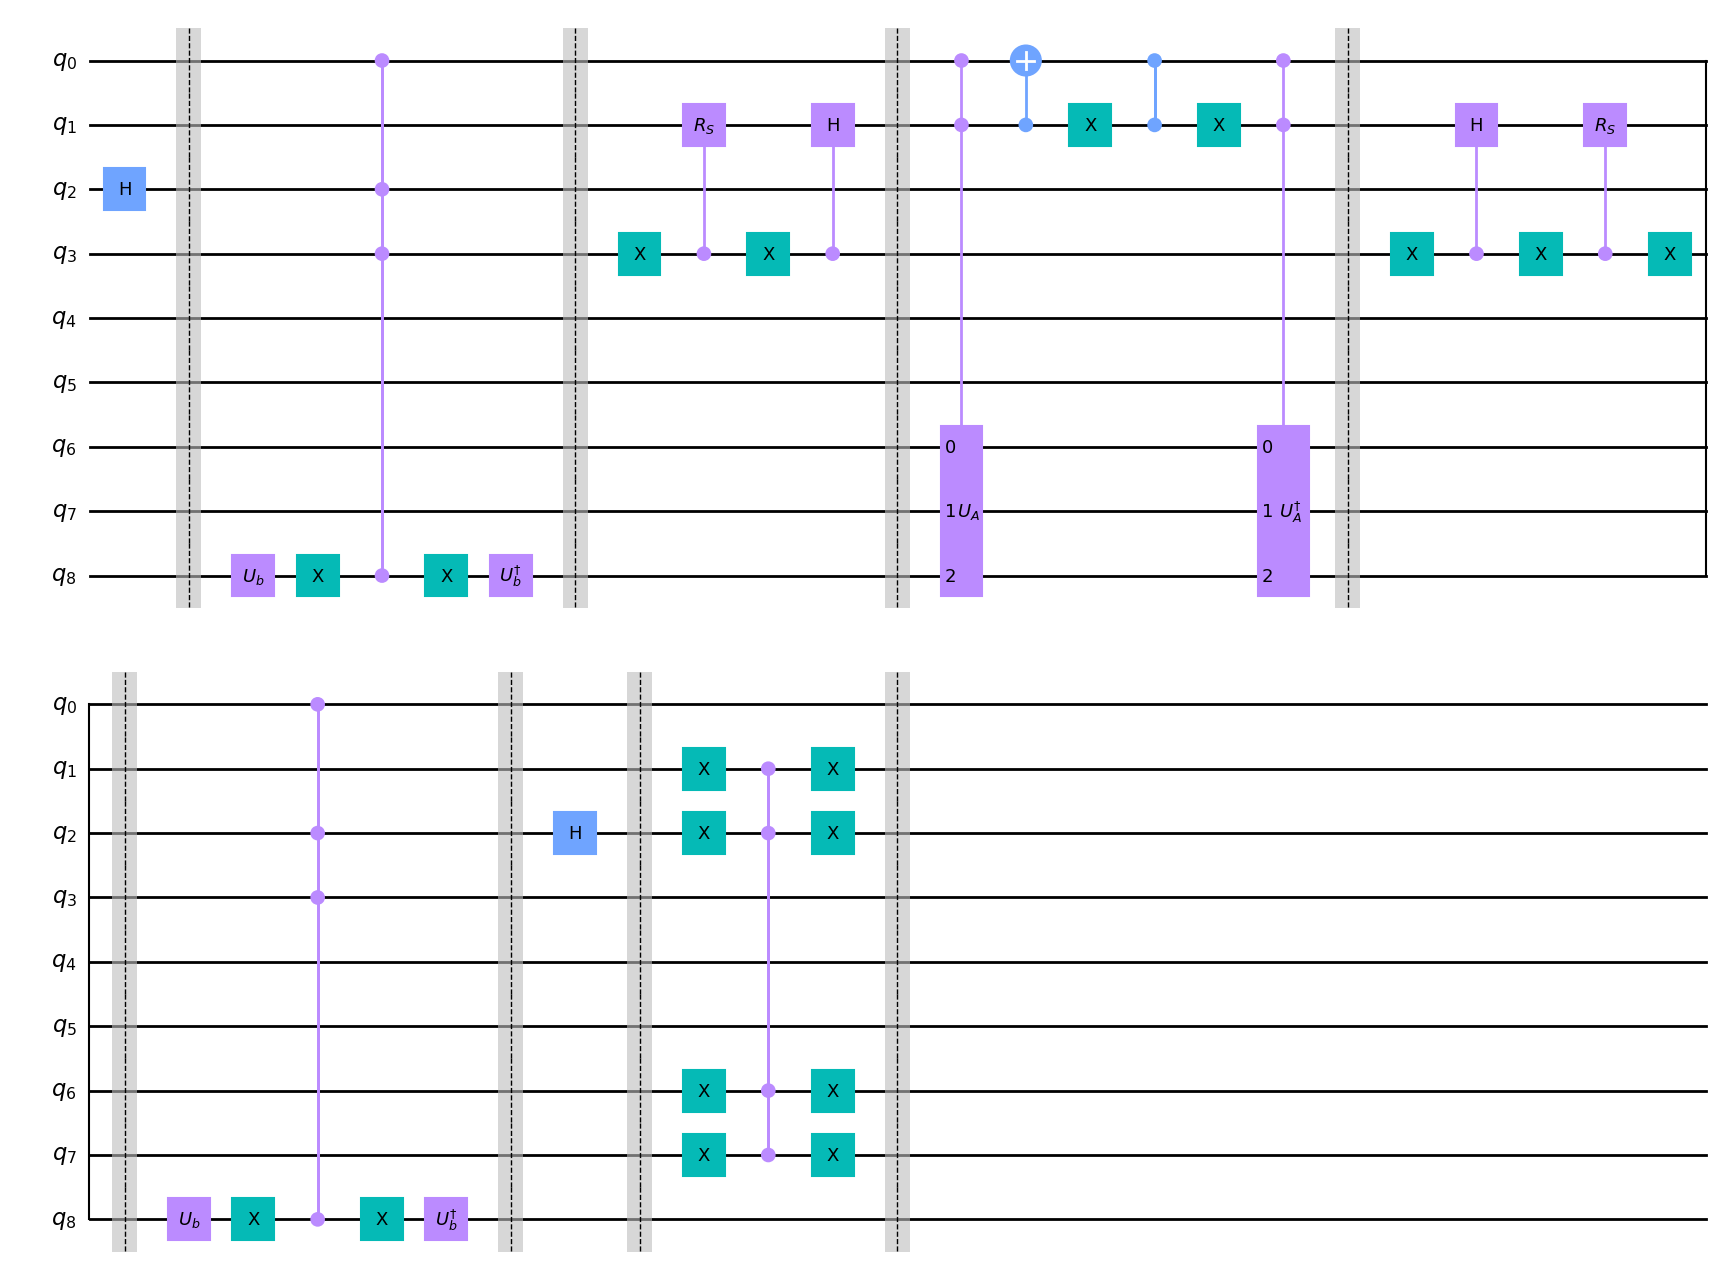

In [6]:
# Creating circuit
circ = QuantumCircuit(9)
circ.h(qubit=2)
circ.barrier()

circ.append(UnitaryGate(data=U_b.data,label=r'$U_b$'),qargs=[8])
circ.x(qubit=8) # For negative control (empty dot in circuit notation)
mqcz_1 = MCMT('z', num_ctrl_qubits=3, num_target_qubits=1)  # see https://quantumcomputing.stackexchange.com/questions/28139/how-do-i-draw-a-multi-control-cz-gate-or-do-i-have-to-make-my-own-gate
circ.compose(mqcz_1,qubits=[0,2,3,8],inplace=True)

circ.x(qubit=8) # For negative control (empty dot in circuit notation)
circ.append(UnitaryGate(data=U_b_dagger.data,label=r'$U_b^{\dagger}$'),qargs=[8])
circ.barrier()

circ.x(qubit=3) # For negative control (empty dot in circuit notation)
R_s_qubit, control_qubit =1, 3
circ.append(UnitaryGate(data=R_S.data,label=f'$R_S$').control(num_ctrl_qubits=1),qargs=[control_qubit,R_s_qubit])
circ.x(qubit=3) # For negative control (empty dot in circuit notation)
circ.ch(control_qubit=3,target_qubit=1)
circ.barrier()

control_qubit_1, control_qubit_2 = 0,1
circ.append(UnitaryGate(data=U_A.data,label=r'$U_A$').control(num_ctrl_qubits=2),qargs=[control_qubit_1,control_qubit_2,6,7,8])
circ.cx(control_qubit=1,target_qubit=0)
circ.x(qubit=1) # For negative control (empty dot in circuit notation)
mqcz_2 = MCMT('z', num_ctrl_qubits=1, num_target_qubits=1)  # see https://quantumcomputing.stackexchange.com/questions/28139/how-do-i-draw-a-multi-control-cz-gate-or-do-i-have-to-make-my-own-gate
circ.compose(mqcz_2,qubits=[0,1],inplace=True)

circ.x(qubit=1)
circ.append(UnitaryGate(data=U_A_dagger.data,label=r'$U_A^{\dagger}$').control(num_ctrl_qubits=2),qargs=[control_qubit_1,control_qubit_2,6,7,8])
circ.barrier()

circ.x(qubit=3)

circ.ch(control_qubit=3,target_qubit=1)
circ.x(qubit=3)# For negative control (empty dot in circuit notation)
R_s_qubit, control_qubit =1, 3
circ.append(UnitaryGate(data=R_S.data,label=f'$R_S$').control(num_ctrl_qubits=1),qargs=[control_qubit,R_s_qubit])
circ.x(qubit=3) # For negative control (empty dot in circuit notation)
circ.barrier()

circ.append(UnitaryGate(data=U_b.data,label=r'$U_b$'),qargs=[8])
circ.x(qubit=8) # For negative control (empty dot in circuit notation)
circ.compose(mqcz_1,qubits=[0,2,3,8],inplace=True)
circ.x(qubit=8) # For negative control (empty dot in circuit notation)
circ.append(UnitaryGate(data=U_b_dagger.data,label=r'$U_b^{\dagger}$'),qargs=[8])
circ.barrier()
circ.h(qubit=2)

circ.barrier()
circ.x(qubit=1)
circ.x(qubit=2)
circ.x(qubit=6)
circ.x(qubit=7)
mqcz_3 = MCMT('z', num_ctrl_qubits=3, num_target_qubits=1)  # see https://quantumcomputing.stackexchange.com/questions/28139/how-do-i-draw-a-multi-control-cz-gate-or-do-i-have-to-make-my-own-gate
circ.compose(mqcz_1,qubits=[1,2,6,7],inplace=True)
circ.x(qubit=1)
circ.x(qubit=2)
circ.x(qubit=6)
circ.x(qubit=7)

circ.barrier()

circ.draw('mpl')